## Purpose of this notebook

This is an (unfinished) start to see whether it is valuable to interact with the open data available at at [data.overheid.nl/zoek](https://data.overheid.nl/zoek), 
in particular the API that exposes most of that information mechanically.

The site contains an index of datasets from centralized and decentralized organisations, from ZBOs, and more.

There is an API to request the same information as is available on the site. 

It is built on CKAN ('Comprehensive Knowledge Archive Network', see e.g. [the wikipedia description](https://en.wikipedia.org/wiki/CKAN), [its website](https://ckan.org/), [its API docs](https://docs.ckan.org/en/latest/api/index.html)),
which is a way of organizing/updating/exposing/requesting open data when that lends itself to little packages of largely-self-described ''things''
(more technically, it is a Data Management System that is currently mostly used for data portals).

The code below is a quick and dirty, manually written start of an interface towards https://data.overheid.nl/data/api/3
which has some documentation at https://docs.datacommunities.nl/data-overheid-nl-documentatie/data.overheid.nl-werking/apis-met-de-data-van-data.overheid.nl

Note also that you can query the API for a description of its functions, 
but that this is _generic_ API documentation, e.g. https://data.overheid.nl/data/api/3/action/help_show?name=package_show


And yes, there are much more capable CKAN libraries, 
but if we just want to fetch a few bits of JSON, we can do without that dependency.

In [1]:
import json, pprint, time, urllib.parse, random

import wetsuite.helpers.net
import wetsuite.helpers.localdata
import wetsuite.helpers.notebook

### What it calls 'Datasets' or 'packages'

https://data.overheid.nl/data/api/3/action/package_search

is the data form of

https://data.overheid.nl/datasets

However, don't expect "dataset" to mean "wrapped, packaged, hosted, and archived data".

It may mean little more than "someone at some point made a file and sent it to someone".

In [ ]:
# https://data.overheid.nl/data/api/3/action/package_list
# 
# https://data.overheid.nl/data/api/3/action/package_show?id=-7aisjxlssbgrg
# https://data.overheid.nl/data/api/3/action/package_search?q=name:-7aisjxlssbgrg
# 
# TODO: read docs, it's not clear to me how this identifier/name should be used
# This works but may not be the intent: https://data.overheid.nl/data/api/3/action/package_search?q=name:14592-waterplantenbedekking-ijsselmeergebied---fijne-waterranonkel---2015

In [ ]:
# while you could 
# - get the identifier/name for each dataset/package using /action/package_list
# - and then feed each to /action/package_show?id=name
if False:
    ckan_show = wetsuite.helpers.localdata.LocalKV( 'ckan_show.db', str, bytes ) # keep local copy so we can update our knowledge faster

    BASE_URL = 'https://data.overheid.nl/data/api/3'

    def package_list():
        ' return list of the _names_ of all packages '
        data = wetsuite.helpers.net.download(BASE_URL+'/action/package_list')
        return json.loads( data )['result']

    def package_show(id:str, be_nice_to_server=True):
        ' return list of the _names_ of all packages '
        url = BASE_URL+'/action/package_show?id=%s'%urllib.parse.quote(id)
        data, fromcache = wetsuite.helpers.localdata.cached_fetch(ckan_show, url) 
        if be_nice_to_server and not fromcache:
            time.sleep(2)
        return json.loads( data )

    collected = {}
    for id in wetsuite.helpers.notebook.ProgressBar( package_list() ):
        #print(id)
        ps = package_show( id )    
        collected[id] = ps['result']

In [5]:
# ...it is actually much faster  (should take a minute, two if we're being slightly nice to the server)
# and lighter on the service,
# and more up-to-date (no cacheing necessary)
# to do a search-for-everything
i, atatime = 0, 500
results = []

# Yes, this code deserves some cleanup to be more readable
while True:
    url = BASE_URL+'/action/package_search?start=%d&rows=%d'%(i, atatime)
    print( url )
    bytedata = wetsuite.helpers.net.download( url )
    #print( bytedata)
    d = json.loads( bytedata )
    results_chunk = d.get('result').get('results')
    if len(results_chunk)==0:
        break
    results.extend( results_chunk )
    i += atatime
    time.sleep(1) # be slightly nice to server

https://data.overheid.nl/data/api/3/action/package_search?start=0&rows=500
https://data.overheid.nl/data/api/3/action/package_search?start=500&rows=500
https://data.overheid.nl/data/api/3/action/package_search?start=1000&rows=500
https://data.overheid.nl/data/api/3/action/package_search?start=1500&rows=500
https://data.overheid.nl/data/api/3/action/package_search?start=2000&rows=500
https://data.overheid.nl/data/api/3/action/package_search?start=2500&rows=500
https://data.overheid.nl/data/api/3/action/package_search?start=3000&rows=500
https://data.overheid.nl/data/api/3/action/package_search?start=3500&rows=500
https://data.overheid.nl/data/api/3/action/package_search?start=4000&rows=500
https://data.overheid.nl/data/api/3/action/package_search?start=4500&rows=500
https://data.overheid.nl/data/api/3/action/package_search?start=5000&rows=500
https://data.overheid.nl/data/api/3/action/package_search?start=5500&rows=500
https://data.overheid.nl/data/api/3/action/package_search?start=6000

Okay, now we have a lot of metadata that looks something like:

In [8]:
random.choice(results)

{'dataset_status': 'http://data.overheid.nl/status/beschikbaar',
 'maintainer': None,
 'issued': '2023-12-05T00:00:00',
 'contact_point_email': 'teamgeo@pzh.nl',
 'authority': 'http://standaarden.overheid.nl/owms/terms/Zuid-Holland',
 'maintainer_email': None,
 'num_tags': 8,
 'metadata_language': 'http://publications.europa.eu/resource/authority/language/NLD',
 'high_value': 'false',
 'contact_point_name': 'Provincie Zuid-Holland',
 'metadata_created': '2023-12-19T06:21:27.822634',
 'relationships_as_object': [],
 'metadata_modified': '2024-10-16T11:27:45.626947',
 'author': None,
 'author_email': None,
 'tags': [{'vocabulary_id': None,
   'state': 'active',
   'display_name': 'agrarisch-natuurbeheer',
   'id': 'ed775d95-7004-48ed-8ee8-d97975a6f6f7',
   'name': 'agrarisch-natuurbeheer'},
  {'vocabulary_id': None,
   'state': 'active',
   'display_name': 'beheer',
   'id': 'b1902fd7-d735-4aad-bdd6-0fb94bd4d789',
   'name': 'beheer'},
  {'vocabulary_id': None,
   'state': 'active',
   '

Let's first see what topics this seems to be on

2024-11-20 12:34:58.241055: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-20 12:34:58.282712: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-20 12:35:00.084926: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-20 12:35:00.086117: I tensorflow/comp

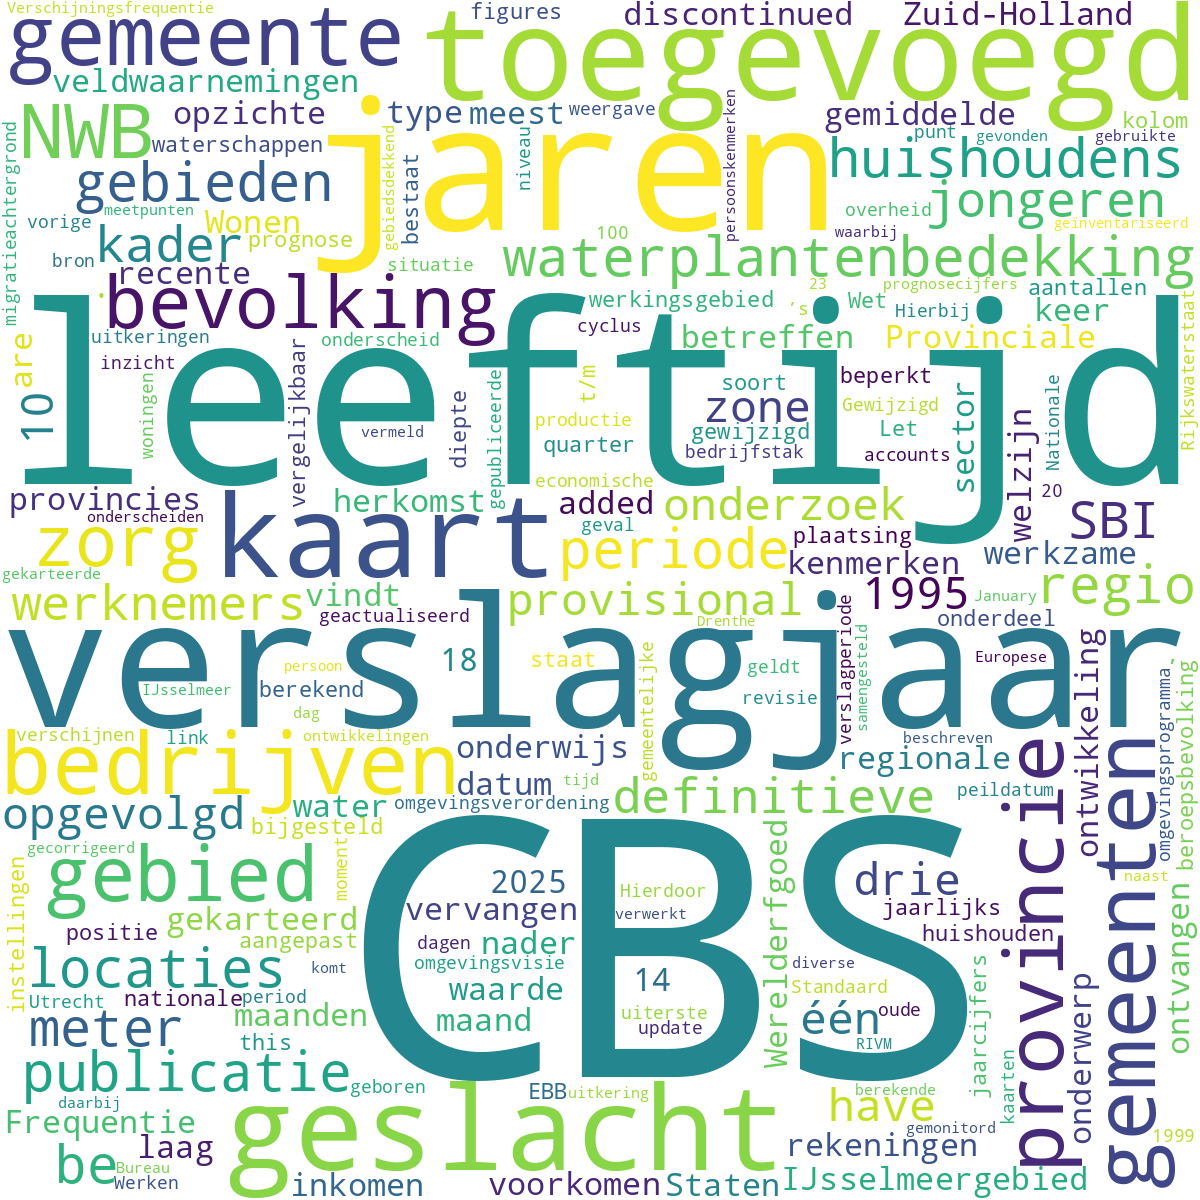

In [9]:
import wetsuite.extras.word_cloud
import wetsuite.helpers.strings
import wetsuite.helpers.spacy
import spacy

nlp = spacy.load("nl_core_news_lg")

countses = [] # we do a frequency count for each item's text,  then later merge it into one big count.

for case in list(collected.values())[::1]:
    #print('='*80)
    #pprint.pprint( case)
    #print( case['notes'] )
    doc = nlp( case['notes'] )
    indiv_counts = wetsuite.extras.word_cloud.count_from_stringlist(
        wetsuite.helpers.spacy.interesting_words( doc, as_text=True ), # this is slower, but less messy
        stopwords_i=list(wetsuite.helpers.strings.stopwords_nl)+[ 
            # some aggressive removal of common words to, hopefully, be left with some indication of what the data is
            'januari','februari','maart','april','mei','juni','juli','augustus','september','oktober','november','december','kwartaal',
            '2024','2023','2022','2021','2020','2019','2018','2017','2016','2015',
            '2014','2013','2012','2011','2010','2009','2008','2007','2006','2005','2004','2003','2002','2001','2000',
            '1','2','3','4','5','6','6','7','8','9','12','15','25','30','31','twee','basis','been','vier','voorgaande','ingedeeld','uitgevoerd','staan','zeggen',
            'personen','definitief','opgenomen','tabel','tabellen','totaal','versie','betreft','deel','waarin','via','totale','vinden',
            'aantal','maken','gemaakt','Status','bevat','tweede','wegen','wijzigingen','bestand','weergegeven','afkomstig',
            'paragraaf','cijfers','gegevens','nieuwe','jaar','beschikbaar','tabel','komen','stopgezet','toepassing',
            'the','zie','daarnaast','data','dataset','informatie','new','and','per','from','geeft','gaat','gebruik','gebruikt','',
            'Nederland','Nederlandse','voorlopig','gepubliceerd','vastgesteld','indeling','betrekking','verschillende','verkrijgen',
            'vinden','volgende','uitgesplitst','voorlopige','gebaseerd','published','toegang','onderwerpen','overige',
            'overige','genoemd','grote','datasets','plaats','laatste','zien','gevolg','uitkomsten','','',
            ]
        )
    countses.append( indiv_counts )
    for resource in case['resources']:
        descr = resource['description'] 
        if descr.strip().lower() not in ('download', 'landingpage', 'accespoint', 'accesspoint', 'endpoint'):
            pass
            #print('-'*80)
            #print( descr )
            #indiv_counts = wetsuite.extras.word_cloud.count_from_string( descr )
            #countses.append( indiv_counts )

merged = wetsuite.extras.word_cloud.merge_counts( countses )
wetsuite.extras.word_cloud.wordcloud_from_freqs( merged, width=1200, height=1200 )


## Dataverzoeken

https://data.overheid.nl/json/api/1/action/datarequest_search

is the data form of:

https://data.overheid.nl/community/dataverzoeken


Note that due to the way these are answered, 
these do not necessarily provide data publicly
and if they do, it often does not include an easily findable link.


https://data.overheid.nl/json/api/1/action/datarequest_show?id=1762




### Toepassingen
  - https://data.overheid.nl/community/toepassingen

https://data.overheid.nl/json/api/1/action/application_search

is the data form of:

https://data.overheid.nl/community/toepassingen




### Organisaties

https://data.overheid.nl/json/api/1/action/organization_search

is the data form of

https://data.overheid.nl/community/organisaties





### Groepen


The page https://data.overheid.nl/community/groepen lists groupings of datasets,

https://data.overheid.nl/json/api/1/action/group_search is the data form of 




### Tags

https://data.overheid.nl/data/api/3/action/tag_list





### Communities

https://data.overheid.nl/json/api/1/action/community_search

is the data form of

https://data.overheid.nl/search/communities





## Waardelijsten

Certain metadata fields have values you would look up in:

https://dcat-ap-donl.readthedocs.io/en/latest/valuelists.html

https://waardelijsten.dcat-ap-donl.nl/